# Exploratory Data Analysis & Preprocessing
## Data Preprocessing
### Importing the Dataset

In [1]:
import pandas as pd
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100


df = pd.concat(
    [
        pd.read_csv(
            f"data/OraclesElixir/{year}_LoL_esports_match_data_from_OraclesElixir.csv",
            dtype={"url": "str"}
        )
        for year in range(2020, 2025)
    ],
    ignore_index=True
)

rows, cols = df.shape
print(f"The CSV file has {rows} rows and {cols} columns.")

print(df.columns.tolist())


The CSV file has 666168 rows and 161 columns.
['gameid', 'datacompleteness', 'url', 'league', 'year', 'split', 'playoffs', 'date', 'game', 'patch', 'participantid', 'side', 'position', 'playername', 'playerid', 'teamname', 'teamid', 'champion', 'ban1', 'ban2', 'ban3', 'ban4', 'ban5', 'pick1', 'pick2', 'pick3', 'pick4', 'pick5', 'gamelength', 'result', 'kills', 'deaths', 'assists', 'teamkills', 'teamdeaths', 'doublekills', 'triplekills', 'quadrakills', 'pentakills', 'firstblood', 'firstbloodkill', 'firstbloodassist', 'firstbloodvictim', 'team kpm', 'ckpm', 'firstdragon', 'dragons', 'opp_dragons', 'elementaldrakes', 'opp_elementaldrakes', 'infernals', 'mountains', 'clouds', 'oceans', 'chemtechs', 'hextechs', 'dragons (type unknown)', 'elders', 'opp_elders', 'firstherald', 'heralds', 'opp_heralds', 'void_grubs', 'opp_void_grubs', 'firstbaron', 'barons', 'opp_barons', 'firsttower', 'towers', 'opp_towers', 'firstmidtower', 'firsttothreetowers', 'turretplates', 'opp_turretplates', 'inhibitor

### Filter for Complete Matches Only

In [2]:
num_complete_rows = df[df["datacompleteness"] == 'complete'].shape[0]
total_rows = df.shape[0]
ratio = num_complete_rows / total_rows
print(f"Number of rows where datacompleteness is 'complete': {num_complete_rows}")
print(f"Ratio of 'complete' rows to total rows: {ratio:.4f}")

df = df[df["datacompleteness"] == 'complete']


Number of rows where datacompleteness is 'complete': 590184
Ratio of 'complete' rows to total rows: 0.8859


### Aggregate Individual Stats to Team-Level Rows

In [3]:
team_rows = df[df['position'] == 'team'].copy()
player_rows = df[df['position'] != 'team']

positions = ['top', 'jng', 'mid', 'bot', 'sup']

for pos in positions:
    champ_col = (
        player_rows[player_rows['position'] == pos]
        .loc[:, ['gameid', 'side', 'champion']]
        .rename(columns={'champion': f'{pos}_champ'})
    )
    
    team_rows = team_rows.merge(champ_col, on=['gameid', 'side'], how='left')
df = team_rows


### Visualize Feature Correlations

In [4]:
correlation_void = df['void_grubs'].corr(df['result'])  
print("Correlation with void:", correlation_void)

correlation_monsterkillsownjungle = df['monsterkillsownjungle'].corr(df['result'])  
print("Correlation with monsterkillsownjungle:", correlation_monsterkillsownjungle)

correlation_turretplates = df['turretplates'].corr(df['result'])  
print("Correlation with turretplates:", correlation_turretplates)

correlation_heralds = df['heralds'].corr(df['result'])  
print("Correlation with heralds:", correlation_heralds)

correlation_visionscore = df['visionscore'].corr(df['result'])  
print("Correlation with visionscore:", correlation_visionscore)

correlation_vspm = df['vspm'].corr(df['result'])  
print("Correlation with vspm:", correlation_vspm)

correlation_minionkills = df['minionkills'].corr(df['result'])  
print("Correlation with minionkills:", correlation_minionkills)

correlation_cspm = df['cspm'].corr(df['result'])  
print("Correlation with cspm:", correlation_cspm)

Correlation with void: 0.1548435396610444
Correlation with monsterkillsownjungle: 0.031337234268704876
Correlation with turretplates: 0.31858667778259764
Correlation with heralds: 0.2879741715686035
Correlation with visionscore: 0.18561223660246232
Correlation with vspm: 0.33933797406426885
Correlation with minionkills: 0.06874916061568377
Correlation with cspm: 0.3519918718002369


### Remove Unnecessary or Redundant Features

In [5]:
columns_to_drop = (
    df.columns[1:11]  # Metadata columns
    .union(df.columns[12:18])  # Additional metadata columns
    .union(df.columns[18:28])  # BP data
    .union(df.columns[30:43])  # End game data columns
    .union(df.columns[48:57])  # Drake-related columns
    .union(df.columns[40:43])  # Individual data columns
    .union(pd.Index([df.columns[78]]))  # Specific column (damageshare)
    .union(pd.Index([df.columns[91]]))  # Specific column (earnedgoldshare)
    .union(pd.Index([df.columns[95]]))  # Specific column (total cs)
    .union(pd.Index([df.columns[28]]))  # Specific column (gamelength)
    .union(df.columns[131:161])  # Data after 20 minutes
)

df.drop(columns=columns_to_drop, axis=1, inplace=True)



### Identify Null Values

In [6]:
# Print the count of null values in each column
print("Null values in each column:")
null_counts = df.isnull().sum()
null_columns = null_counts[null_counts > 0]
print(null_columns)
print("----------------------------------------------------")

# Calculate the ratio of null values for each column
null_ratio = (null_counts / total_rows)

# Filter and print only the columns where the ratio of null values is greater than 0
null_columns_with_ratio = null_ratio[null_ratio > 0]
print("Columns with null values and their ratios:")
print(null_columns_with_ratio)


Null values in each column:
firstdragon                    8
heralds                     3160
opp_heralds                 3160
void_grubs                 81506
opp_void_grubs             81506
firstbaron                   436
firsttower                    22
firstmidtower                 18
turretplates               39006
opp_turretplates           39006
inhibitors                   116
opp_inhibitors               116
damagetochampions             22
dpm                           22
damagetakenperminute          22
wardsplaced                   22
wpm                           22
wardskilled                   22
wcpm                          22
controlwardsbought            22
visionscore                 3044
vspm                        3044
earnedgold                    22
earned gpm                    22
minionkills                 2650
monsterkills                  22
monsterkillsownjungle      59380
monsterkillsenemyjungle    59380
cspm                        2628
goldat10       

### Drop or fill null values

In [7]:
df['void_grubs'] = df['void_grubs'].fillna(0)
df['opp_void_grubs'] = df['opp_void_grubs'].fillna(0)
df['turretplates'] = df['turretplates'].fillna(0)
df['opp_turretplates'] = df['opp_turretplates'].fillna(0)
df['heralds'] = df['heralds'].fillna(0)
df['opp_heralds'] = df['opp_heralds'].fillna(0)


df['cspm'] = df['cspm'].fillna(df['cspm'].median())
df['vspm'] = df['vspm'].fillna(df['vspm'].median())
df['visionscore'] = df['visionscore'].fillna(df['visionscore'].median())
df.drop(columns=['monsterkillsownjungle', 'monsterkillsenemyjungle'], inplace=True)
df.dropna(inplace=True)
df.drop(columns=['gameid', 'side'], inplace=True)


### Verify That All Missing Values Are Handled

In [8]:
# Print the count of null values in each column
print("Null values in each column:")
null_counts = df.isnull().sum()
null_columns = null_counts[null_counts > 0]
print(null_columns)
print("")

# Calculate the ratio of null values for each column
null_ratio = (null_counts / total_rows)

# Filter and print only the columns where the ratio of null values is greater than 0
null_columns_with_ratio = null_ratio[null_ratio > 0]
print("Columns with null values and their ratios:")
print(null_columns_with_ratio)


Null values in each column:
Series([], dtype: int64)

Columns with null values and their ratios:
Series([], dtype: float64)


### Convert Categorical Variables into Numerical Format

In [9]:
from sklearn.preprocessing import LabelEncoder

champ_cols = ['top_champ', 'jng_champ', 'mid_champ', 'bot_champ', 'sup_champ']

all_champs = pd.concat([df[col] for col in champ_cols], axis=0).unique()

le = LabelEncoder()
le.fit(all_champs)

for col in champ_cols:
    df[col] = le.transform(df[col])

### Preview the Dataset

In [ ]:
# Concatenate the head and tail of the dataframe
head_and_tail = pd.concat([df.head(), df.tail()])

display(pd.concat([df.head(), df.tail()]))

,result,team kpm,ckpm,firstdragon,dragons,opp_dragons,elders,opp_elders,firstherald,heralds,opp_heralds,void_grubs,opp_void_grubs,firstbaron,barons,opp_barons,firsttower,towers,opp_towers,firstmidtower,firsttothreetowers,turretplates,opp_turretplates,inhibitors,opp_inhibitors,damagetochampions,dpm,damagetakenperminute,damagemitigatedperminute,wardsplaced,wpm,wardskilled,wcpm,controlwardsbought,visionscore,vspm,totalgold,earnedgold,earned gpm,goldspent,gspd,gpr,minionkills,monsterkills,cspm,goldat10,xpat10,csat10,opp_goldat10,opp_xpat10,opp_csat10,golddiffat10,xpdiffat10,csdiffat10,killsat10,assistsat10,deathsat10,opp_killsat10,opp_assistsat10,opp_deathsat10,goldat15,xpat15,csat15,opp_goldat15,opp_xpat15,opp_csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,opp_killsat15,opp_assistsat15,opp_deathsat15,top_champ,jng_champ,mid_champ,bot_champ,sup_champ
0,1,0.4595,0.7568,0.0,2.0,3.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,8.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,77679.0,2099.4324,1975.3243,2302.4595,191.0,5.1622,97.0,2.6216,67.0,380.0,10.2703,68927,44905.0,1213.6486,62275.0,0.004023,-0.38,1049.0,216.0,34.1892,14615.0,17845.0,330.0,14498.0,17982.0,322.0,117.0,-137.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,21953.0,27219.0,507.0,22778.0,28884.0,519.0,-825.0,-1665.0,-12.0,0.0,0.0,1.0,1.0,2.0,0.0,110,30,100,82,88
1,0,0.2973,0.7568,1.0,3.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,4.0,8.0,1.0,1.0,0.0,0.0,0.0,1.0,48685.0,1315.8108,2934.9459,3135.6486,172.0,4.6486,91.0,2.4595,69.0,318.0,8.5946,62709,38687.0,1045.5946,62025.0,-0.004023,0.38,1021.0,271.0,34.9189,14498.0,17982.0,322.0,14615.0,17845.0,330.0,-117.0,137.0,-8.0,0.0,0.0,0.0,0.0,0.0,0.0,22778.0,28884.0,519.0,21953.0,27219.0,507.0,825.0,1665.0,12.0,1.0,2.0,0.0,0.0,0.0,1.0,0,40,83,155,102
2,0,0.1347,0.7005,0.0,1.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,9.0,1.0,0.0,0.0,0.0,0.0,1.0,72963.0,1965.7746,2324.1042,2729.5016,144.0,3.8797,95.0,2.5595,58.0,254.0,6.8433,57283,33190.0,894.2075,56575.0,-0.122771,-4.42,1011.0,183.0,32.1688,14180.0,16947.0,300.0,16194.0,19096.0,334.0,-2014.0,-2149.0,-34.0,0.0,0.0,3.0,3.0,3.0,0.0,21714.0,26869.0,501.0,27198.0,31702.0,557.0,-5484.0,-4833.0,-56.0,0.0,0.0,6.0,6.0,7.0,0.0,52,50,95,82,88
3,1,0.5658,0.7005,1.0,4.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,9.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,65542.0,1765.8374,2861.2214,3192.7167,195.0,5.2537,90.0,2.4248,53.0,397.0,10.6960,72004,47911.0,1290.8217,63975.0,0.122771,4.42,976.0,270.0,33.5698,16194.0,19096.0,334.0,14180.0,16947.0,300.0,2014.0,2149.0,34.0,3.0,3.0,0.0,0.0,0.0,3.0,27198.0,31702.0,557.0,21714.0,26869.0,501.0,5484.0,4833.0,56.0,6.0,7.0,0.0,0.0,0.0,6.0,0,30,100,143,130
4,1,0.7364,0.8767,1.0,4.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,10.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,50728.0,1778.8895,2032.8112,2500.4676,111.0,3.8925,49.0,1.7183,42.0,262.0,9.1876,58078,39248.0,1376.3179,50660.0,0.225957,3.16,806.0,242.0,36.7504,15531.0,19034.0,365.0,14849.0,18419.0,340.0,682.0,615.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,24882.0,30349.0,584.0,22316.0,28252.0,531.0,2566.0,2097.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,107,104,83,155,102
98359,0,0.3009,1.2414,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,2.0,4.0,0.0,0.0,1.0,0.0,1.0,9.0,0.0,0.0,4.0,6.0,0.0,2.0,55961.0,2105.1160,3901.0909,3101.4545,88.0,3.3103,28.0,1.0533,35.0,184.0,6.9216,43774,26127.0,982.8339,43085.0,-0.144248,-2.56,729.0,155.0,33.2539,15293.0,18210.0,321.0,16204.0,19140.0,355.0,-911.0,-930.0,-34.0,2.0,4.0,2.0,2.0,3.0,2.0,24614.0,28419.0,506.0,26236.0,28861.0,516.0,-1622.0,-442.0,-10.0,5.0,14.0,6.0,6.0,14.0,5.0,110,92,159,56,88
98360,1,0.6222,1.0280,0.0,2.0,3.0,0.0,0.0,1.0,1.0,0.0,2.0,4.0,1.0,2.0,0.0,0.0,10.0,5.0,1.0,1.0,3.0,8.0,2.0,1.0,96896.0,2621.1722,3268.1064,3795.3922,135.0,3.6519,59.0,1.5960,53.0,330.0,8.9270,75763,51761.0,1400.2074,68108.0,0.051199,-0.63,1056.0,245.0,35.1939,14738.0,18023.0,328.0,16404.0,18534.0,327.0,-1666.0,-511.0,1.0,0.0,0.0,3.0,3.0,4.0,0.0,24225.0,27391.0,482.0,27475.0,28731.0,503.0,-3250.0,-1340.0,-21.0,4.0,12.0,8.0,8.0,

## EDA

### Class Imbalance

result
1    47741
0    47741
Name: count, dtype: int64

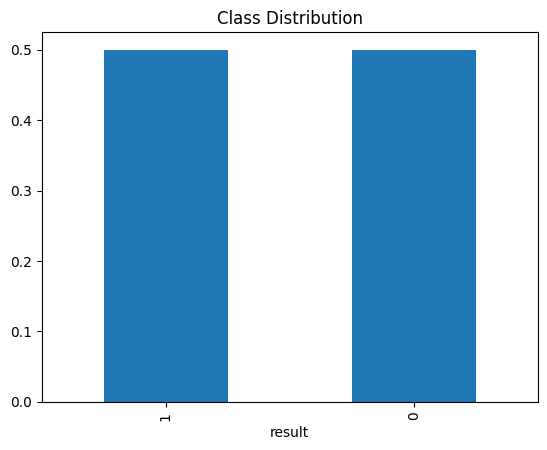

In [11]:
import matplotlib.pyplot as plt

class_counts = df['result'].value_counts()
display(class_counts)

df['result'].value_counts(normalize=True).plot(kind='bar', title='Class Distribution')
plt.show()

### Feature Distributions 

,result,team kpm,ckpm,firstdragon,dragons,opp_dragons,elders,opp_elders,firstherald,heralds,opp_heralds,void_grubs,opp_void_grubs,firstbaron,barons,opp_barons,firsttower,towers,opp_towers,firstmidtower,firsttothreetowers,turretplates,opp_turretplates,inhibitors,opp_inhibitors,damagetochampions,dpm,damagetakenperminute,damagemitigatedperminute,wardsplaced,wpm,wardskilled,wcpm,controlwardsbought,visionscore,vspm,totalgold,earnedgold,earned gpm,goldspent,gspd,gpr,minionkills,monsterkills,cspm,goldat10,xpat10,csat10,opp_goldat10,opp_xpat10,opp_csat10,golddiffat10,xpdiffat10,csdiffat10,killsat10,assistsat10,deathsat10,opp_killsat10,opp_assistsat10,opp_deathsat10,goldat15,xpat15,csat15,opp_goldat15,opp_xpat15,opp_csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,opp_killsat15,opp_assistsat15,opp_deathsat15,top_champ,jng_champ,mid_champ,bot_champ,sup_champ
count,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000
mean,0.500000,0.468663,0.937325,0.499885,2.254037,2.254037,0.055466,0.055466,0.499099,0.867671,0.867671,0.484940,0.484940,0.473911,0.687554,0.687554,0.500000,6.002639,6.002639,0.500000,0.499979,2.795564,2.795564,0.929851,0.929851,68942.542448,2156.892698,3050.151294,2830.685514,97.935548,3.054908,43.533828,1.343993,37.063928,233.957217,7.275602,56882.091190,36124.148478,1141.886254,52651.093337,0.000000,0.000000,804.691984,196.041086,31.641908,15703.156406,18348.044584,316.933904,15703.156406,18348.044584,316.933904,0.000000,0.000000,0.000000,2.179521,3.314468,2.188203,2.179521,3.314468,2.188203,24837.648709,29468.056649,503.296265,24837.648709,29468.056649,503.296265,0.000000,0.000000,0.000000,4.127218,6.869054,4.139429,4.127218,6.869054,4.139429,69.991653,99.487307,83.451960,78.329046,81.901311
std,0.500003,0.259897,0.314571,0.500003,1.399646,1.399646,0.244036,0.244036,0.500002,0.770560,0.770560,1.375632,1.375632,0.499322,0.736129,0.736129,0.500003,3.644046,3.644046,0.500003,0.500003,3.043678,3.043678,1.094713,1.094713,24967.723614,593.950545,593.969929,821.486946,32.289229,0.688795,17.514233,0.396500,12.929679,70.620959,1.287250,11389.849118,8629.670216,203.788607,10613.750860,0.146556,2.471122,149.675449,49.327612,2.662518,1003.033529,914.291994,25.226018,1003.033529,914.291994,25.226018,1525.298739,1092.524343,27.044558,1.952349,3.434741,1.957503,1.952349,3.434741,1.957503,1900.344515,1515.694031,38.268594,1900.344515,1515.694031,38.268594,3093.822543,2098.919725,41.638686,3.045099,5.545658,3.050726,3.045099,5.545658,3.050726,41.666537,43.551758,54.272968,53.212917,40.719287
min,0.000000,0.000000,0.084300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9873.000000,434.296200,1180.115900,797.301600,0.000000,0.000000,0.000000,0.000000,1.000000,27.000000,1.727100,20087.000000,9417.000000,554.655300,16980.000000,-0.590208,-11.070000,266.000000,42.000000,16.976400,12042.000000,12293.0

Feature skewness: 


elders                      4.666631
opp_elders                  4.666631
opp_void_grubs              2.931862
void_grubs                  2.931862
assistsat10                 1.554960
opp_assistsat10             1.554960
opp_killsat10               1.255470
killsat10                   1.255470
opp_deathsat10              1.255165
deathsat10                  1.255165
opp_killsat15               1.229668
killsat15                   1.229668
deathsat15                  1.229173
opp_deathsat15              1.229173
opp_assistsat15             1.205390
assistsat15                 1.205390
inhibitors                  1.199317
opp_inhibitors              1.199317
damagemitigatedperminute    1.004326
damagetochampions           0.996777
opp_turretplates            0.910785
turretplates                0.910785
ckpm                        0.893774
team kpm                    0.830860
wardskilled                 0.799763
opp_barons                  0.788973
barons                      0.788973
o

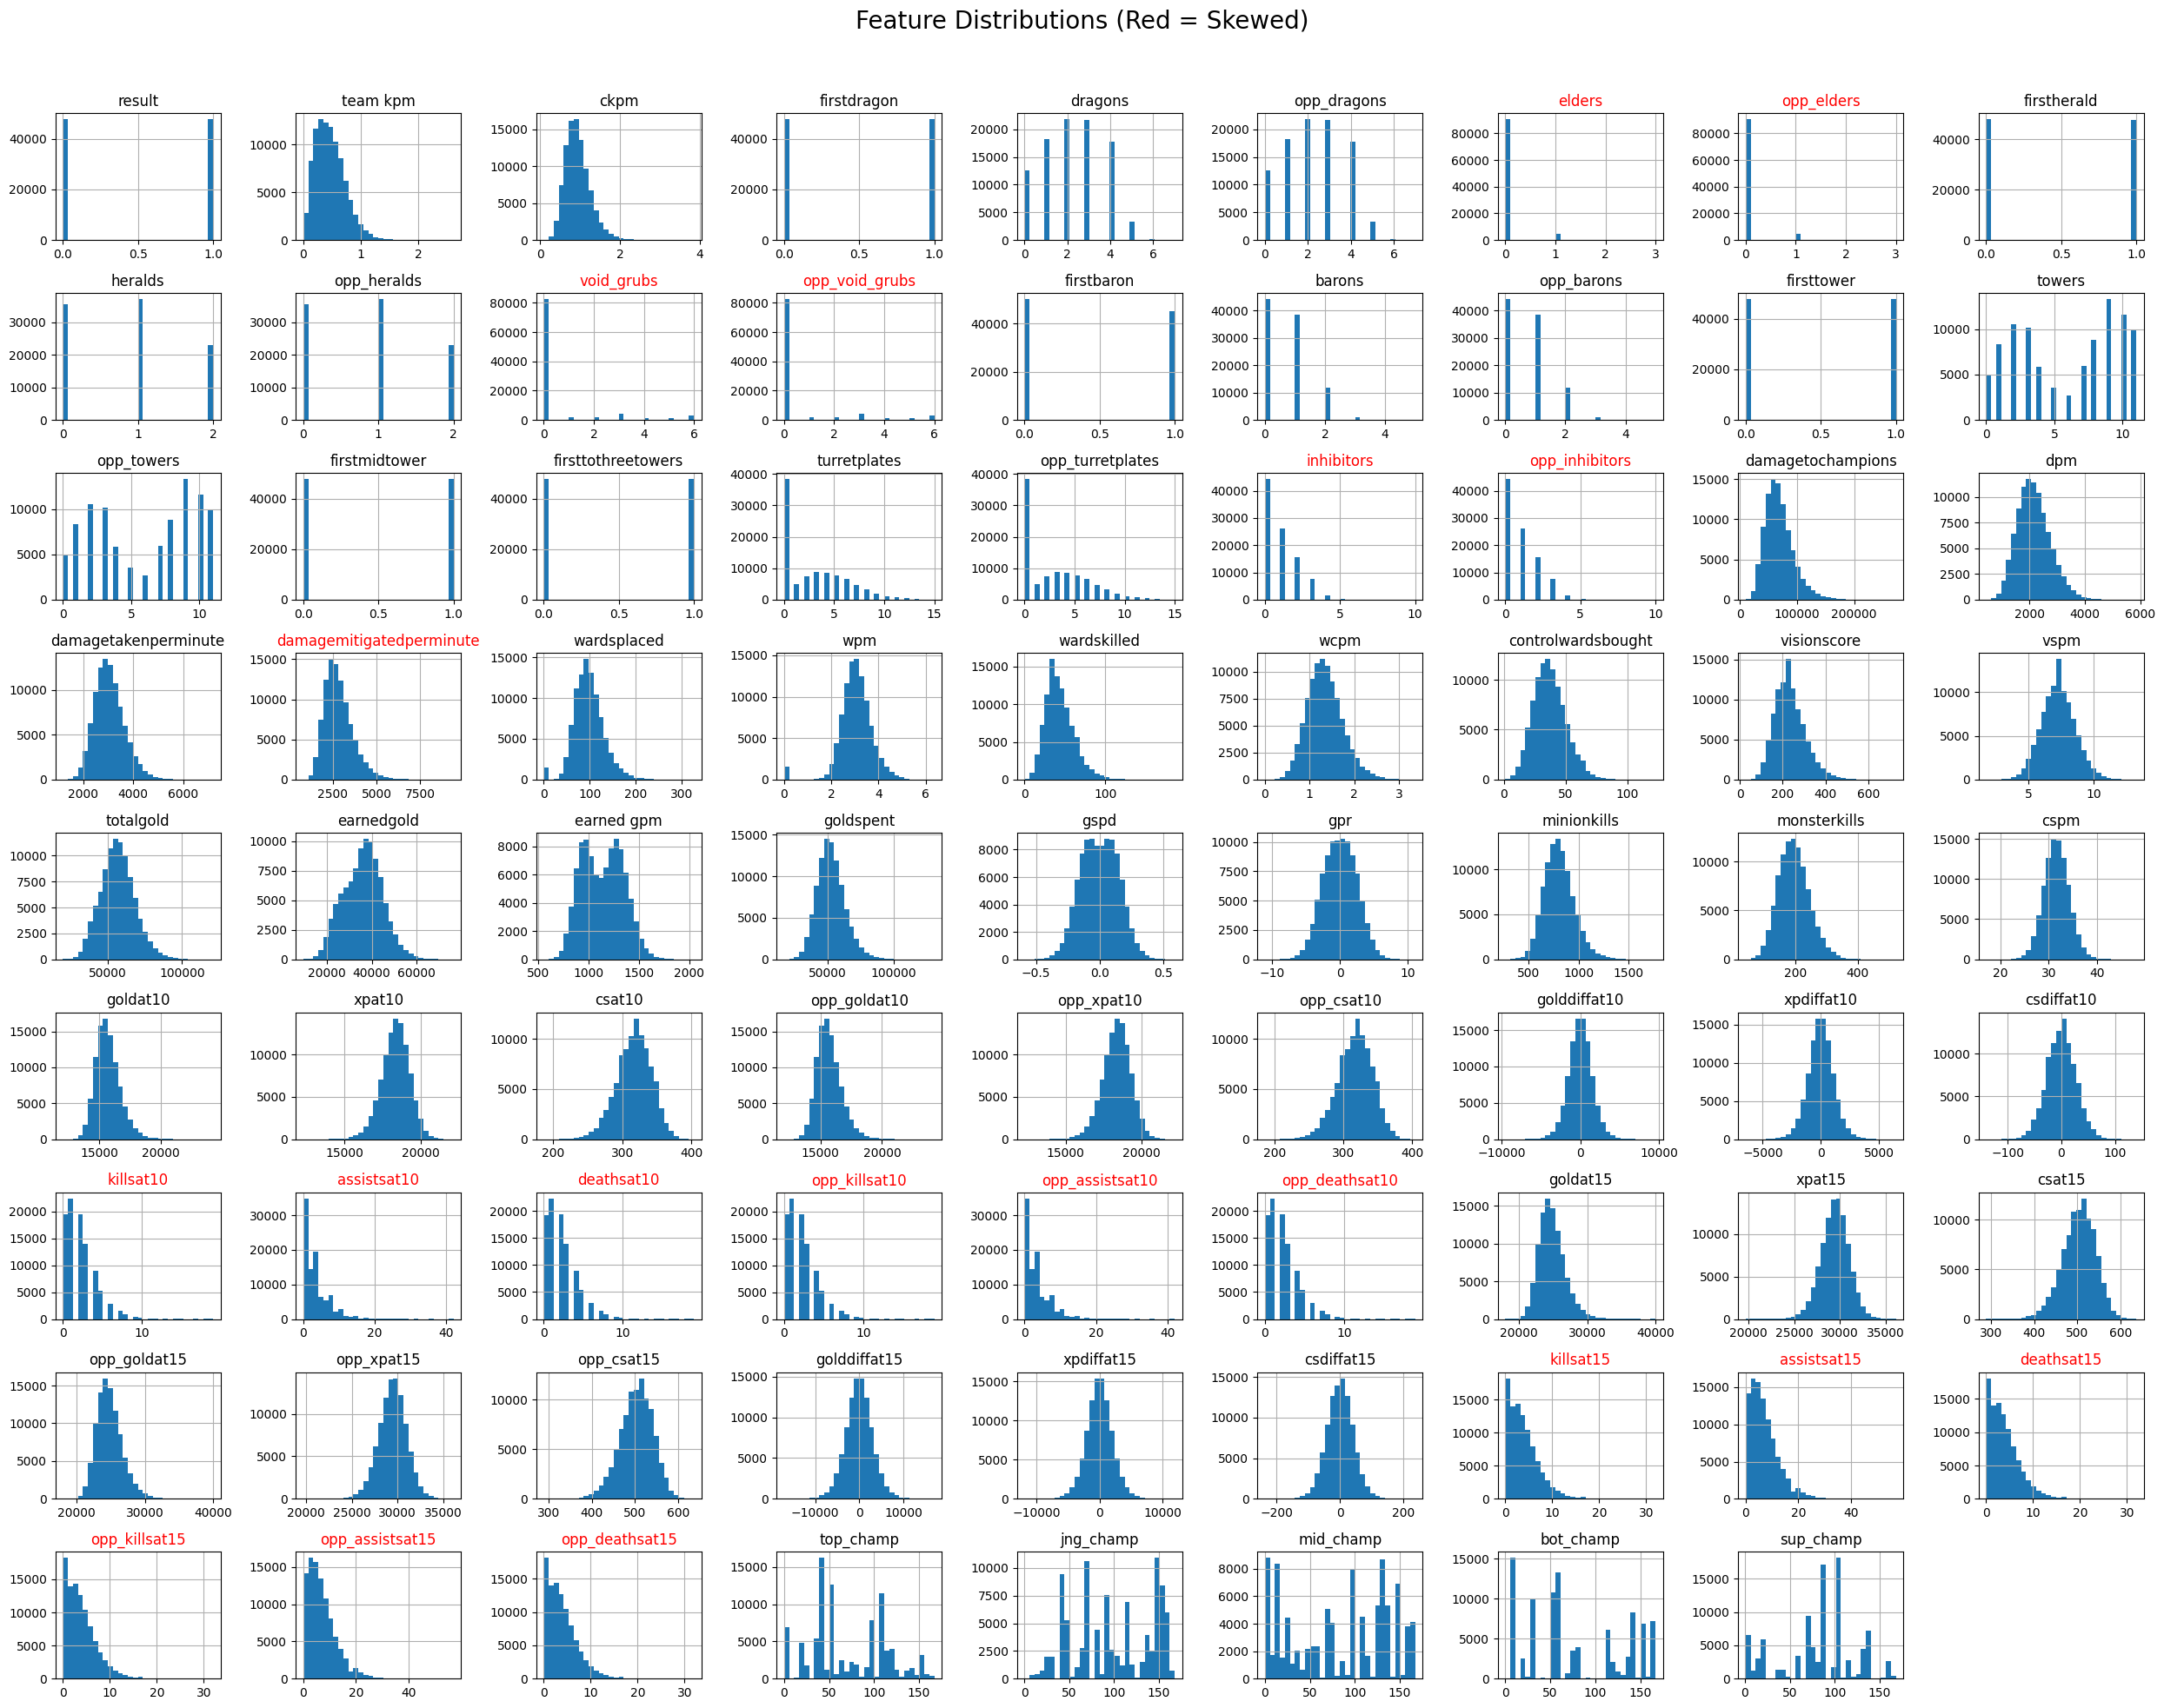

In [12]:
display(df.describe())
print("Feature skewness: ")
display(df.skew().sort_values(ascending=False))

skewed = df.skew()[abs(df.skew()) > 1].index
axes = df.hist(bins=30, figsize=(25, 20))

# Annotate skewed features
for ax in axes.flatten():
    if ax.get_title() in skewed:
        ax.set_title(ax.get_title(), color='red')

plt.suptitle("Feature Distributions (Red = Skewed)", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Apply normalization to skew data

In [13]:
import numpy as np

skewed_features = df.skew()[abs(df.skew()) >= 1].index

for col in skewed_features:
    if (df[col] >= 0).all(): 
        df[col] = np.log1p(df[col])
    else:
        print(f"Feture {col} contains negative values, abort normalization")


In [14]:
from sklearn.preprocessing import MinMaxScaler

label_col = 'result'
binary_cols = [
    'firstdragon', 'firstherald', 'firstbaron', 'firsttower',
    'firstmidtower', 'firsttothreetowers'
]

exclude_cols = [label_col] + binary_cols

normalize_cols = df.columns.difference(exclude_cols)

scaler = MinMaxScaler()
df[normalize_cols] = scaler.fit_transform(df[normalize_cols])

#### Feature Distribution after normalization

,result,team kpm,ckpm,firstdragon,dragons,opp_dragons,elders,opp_elders,firstherald,heralds,opp_heralds,void_grubs,opp_void_grubs,firstbaron,barons,opp_barons,firsttower,towers,opp_towers,firstmidtower,firsttothreetowers,turretplates,opp_turretplates,inhibitors,opp_inhibitors,damagetochampions,dpm,damagetakenperminute,damagemitigatedperminute,wardsplaced,wpm,wardskilled,wcpm,controlwardsbought,visionscore,vspm,totalgold,earnedgold,earned gpm,goldspent,gspd,gpr,minionkills,monsterkills,cspm,goldat10,xpat10,csat10,opp_goldat10,opp_xpat10,opp_csat10,golddiffat10,xpdiffat10,csdiffat10,killsat10,assistsat10,deathsat10,opp_killsat10,opp_assistsat10,opp_deathsat10,goldat15,xpat15,csat15,opp_goldat15,opp_xpat15,opp_csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,opp_killsat15,opp_assistsat15,opp_deathsat15,top_champ,jng_champ,mid_champ,bot_champ,sup_champ
count,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000,95482.000000
mean,0.500000,0.179166,0.226231,0.499885,0.322005,0.322005,0.027009,0.027009,0.499099,0.433836,0.433836,0.100539,0.100539,0.473911,0.137511,0.137511,0.500000,0.545694,0.545694,0.500000,0.499979,0.186371,0.186371,0.214122,0.214122,0.224312,0.318140,0.310519,0.497175,0.300416,0.479404,0.234053,0.400296,0.295606,0.294391,0.480881,0.365092,0.398186,0.393100,0.313344,0.500000,0.500000,0.358173,0.320919,0.469092,0.299898,0.613791,0.600614,0.299898,0.613791,0.600614,0.500000,0.500000,0.500000,0.323776,0.306433,0.324668,0.323776,0.306433,0.324668,0.311274,0.594662,0.617568,0.311274,0.594662,0.617568,0.500000,0.500000,0.500000,0.414195,0.437824,0.414919,0.414195,0.437824,0.414919,0.419112,0.592186,0.499712,0.469036,0.484439
std,0.500003,0.099356,0.083427,0.500003,0.199949,0.199949,0.116510,0.116510,0.500002,0.385280,0.385280,0.265478,0.265478,0.499322,0.147226,0.147226,0.500003,0.331277,0.331277,0.500003,0.500003,0.202912,0.202912,0.219321,0.219321,0.094813,0.109695,0.098629,0.113485,0.099047,0.108092,0.094163,0.118094,0.105981,0.100457,0.111564,0.113014,0.128663,0.136419,0.093234,0.124156,0.111613,0.099518,0.102766,0.085164,0.082162,0.092680,0.115716,0.082162,0.092680,0.115716,0.079767,0.084508,0.096588,0.209216,0.215628,0.209295,0.209216,0.215628,0.209295,0.086548,0.092207,0.110284,0.086548,0.092207,0.110284,0.090696,0.088086,0.087845,0.184520,0.203192,0.184470,0.184520,0.203192,0.184470,0.249500,0.259237,0.324988,0.318640,0.243828
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

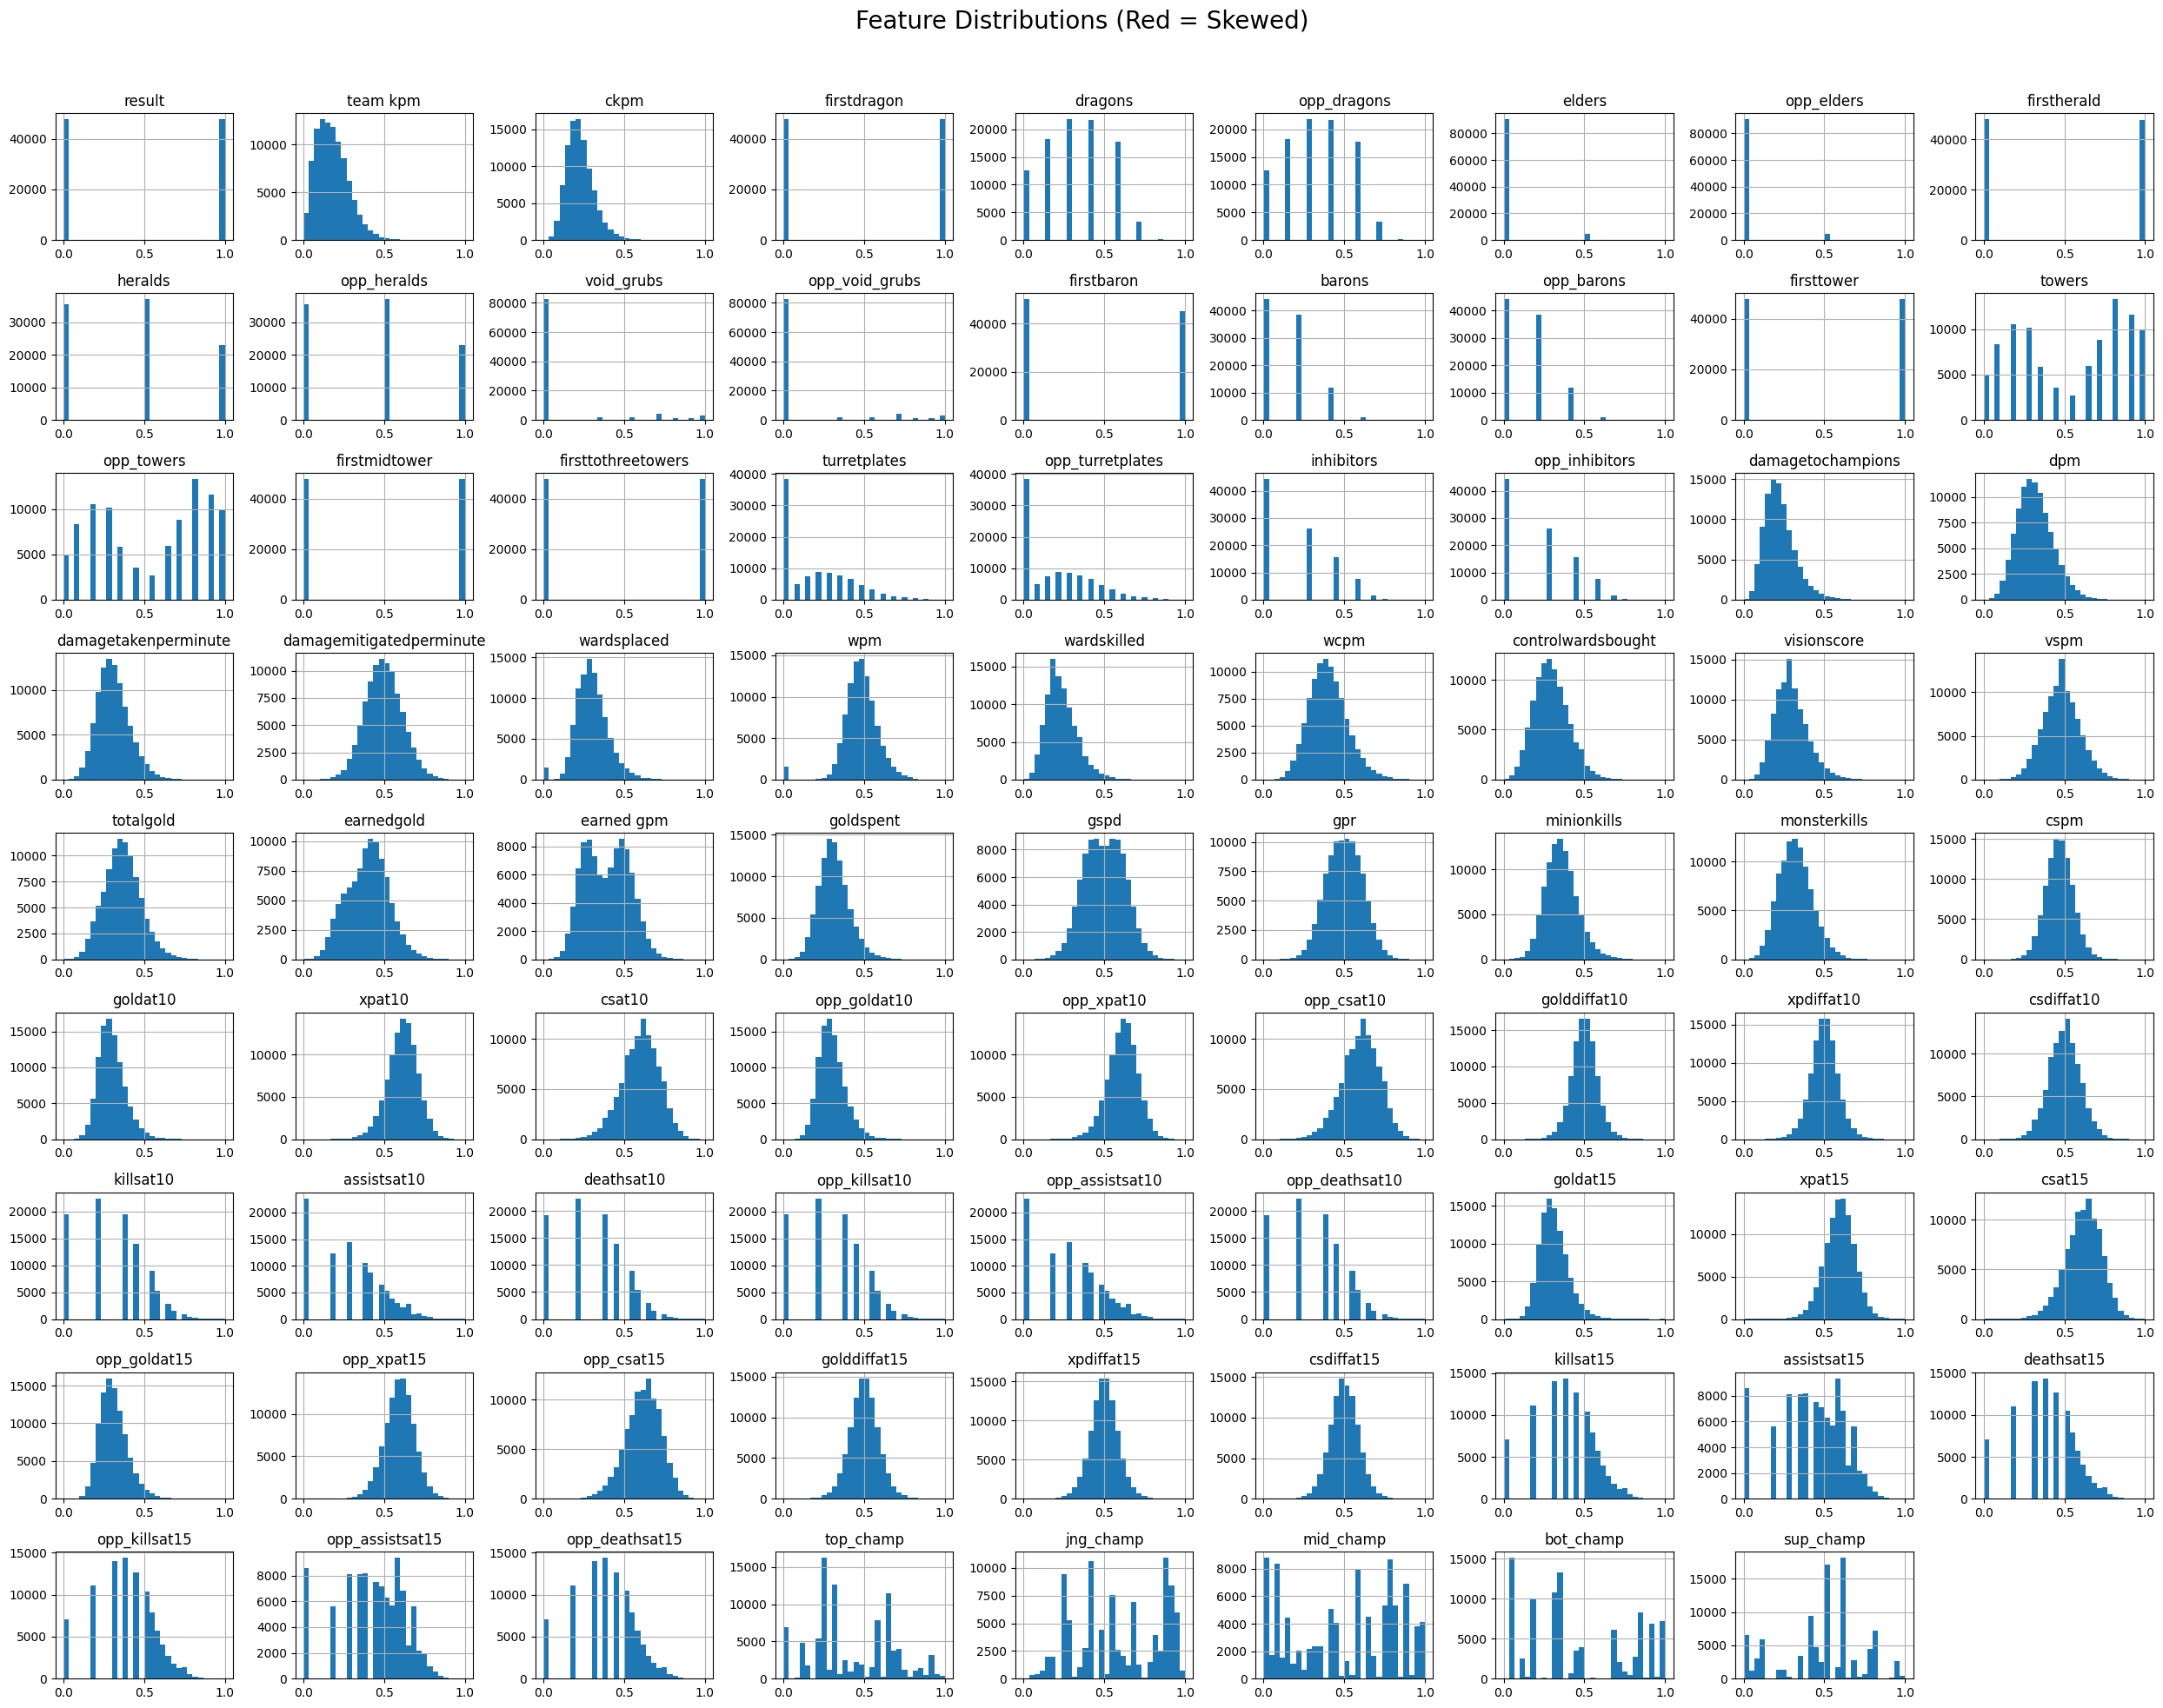

In [15]:
display(df.describe())

axes = df.hist(bins=30, figsize=(25, 20))

plt.suptitle("Feature Distributions (Red = Skewed)", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Correlation with Target

,team kpm,ckpm,firstdragon,dragons,opp_dragons,elders,opp_elders,firstherald,heralds,opp_heralds,void_grubs,opp_void_grubs,firstbaron,barons,opp_barons,firsttower,towers,opp_towers,firstmidtower,firsttothreetowers,turretplates,opp_turretplates,inhibitors,opp_inhibitors,damagetochampions,dpm,damagetakenperminute,damagemitigatedperminute,wardsplaced,wpm,wardskilled,wcpm,controlwardsbought,visionscore,vspm,totalgold,earnedgold,earned gpm,goldspent,gspd,gpr,minionkills,monsterkills,cspm,goldat10,xpat10,csat10,opp_goldat10,opp_xpat10,opp_csat10,golddiffat10,xpdiffat10,csdiffat10,killsat10,assistsat10,deathsat10,opp_killsat10,opp_assistsat10,opp_deathsat10,goldat15,xpat15,csat15,opp_goldat15,opp_xpat15,opp_csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,opp_killsat15,opp_assistsat15,opp_deathsat15,top_champ,jng_champ,mid_champ,bot_champ,sup_champ
result,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.112787,0.226231,0.412078,0.204269,0.439742,0.010121,0.043897,0.400704,0.326983,0.540688,0.091186,0.109892,0.143252,0.045039,0.229983,0.313232,0.252516,0.838873,0.268805,0.220021,0.150832,0.221910,0.026766,0.401479,0.196972,0.27328,0.331936,0.493401,0.294814,0.469427,0.222833,0.379916,0.291693,0.276083,0.443720,0.315921,0.324301,0.28106,0.290080,0.406212,0.421376,0.351337,0.286087,0.439153,0.271708,0.591453,0.579539,0.328088,0.636129,0.621690,0.464005,0.465909,0.467182,0.281262,0.266704,0.367012,0.366291,0.346163,0.282323,0.272891,0.562729,0.592679,0.349658,0.626596,0.642458,0.450587,0.455941,0.463559,0.365745,0.389107,0.463209,0.462645,0.486540,0.366629,0.421273,0.593494,0.499613,0.470655,0.483463
1,0.245545,0.226231,0.587692,0.439742,0.204269,0.043897,0.010121,0.597495,0.540688,0.326983,0.109892,0.091186,0.804570,0.229983,0.045039,0.686768,0.838873,0.252516,0.731195,0.779938,0.221910,0.150832,0.401479,0.026766,0.251652,0.36300,0.289101,0.500948,0.306018,0.489381,0.245273,0.420675,0.299519,0.312700,0.518042,0.414264,0.472071,0.50514,0.336608,0.593788,0.578624,0.365009,0.355751,0.499032,0.328088,0.636129,0.621690,0.271708,0.591453,0.579539,0.535995,0.534091,0.532818,0.366291,0.346163,0.282323,0.281262,0.266704,0.367012,0.349658,0.626596,0.642458,0.272891,0.562729,0.592679,0.549413,0.544059,0.536441,0.462645,0.486540,0.366629,0.365745,0.389107,0.463209,0.416951,0.590879,0.499811,0.467417,0.485415


<Axes: title={'center': 'Feature Mean by Result'}>

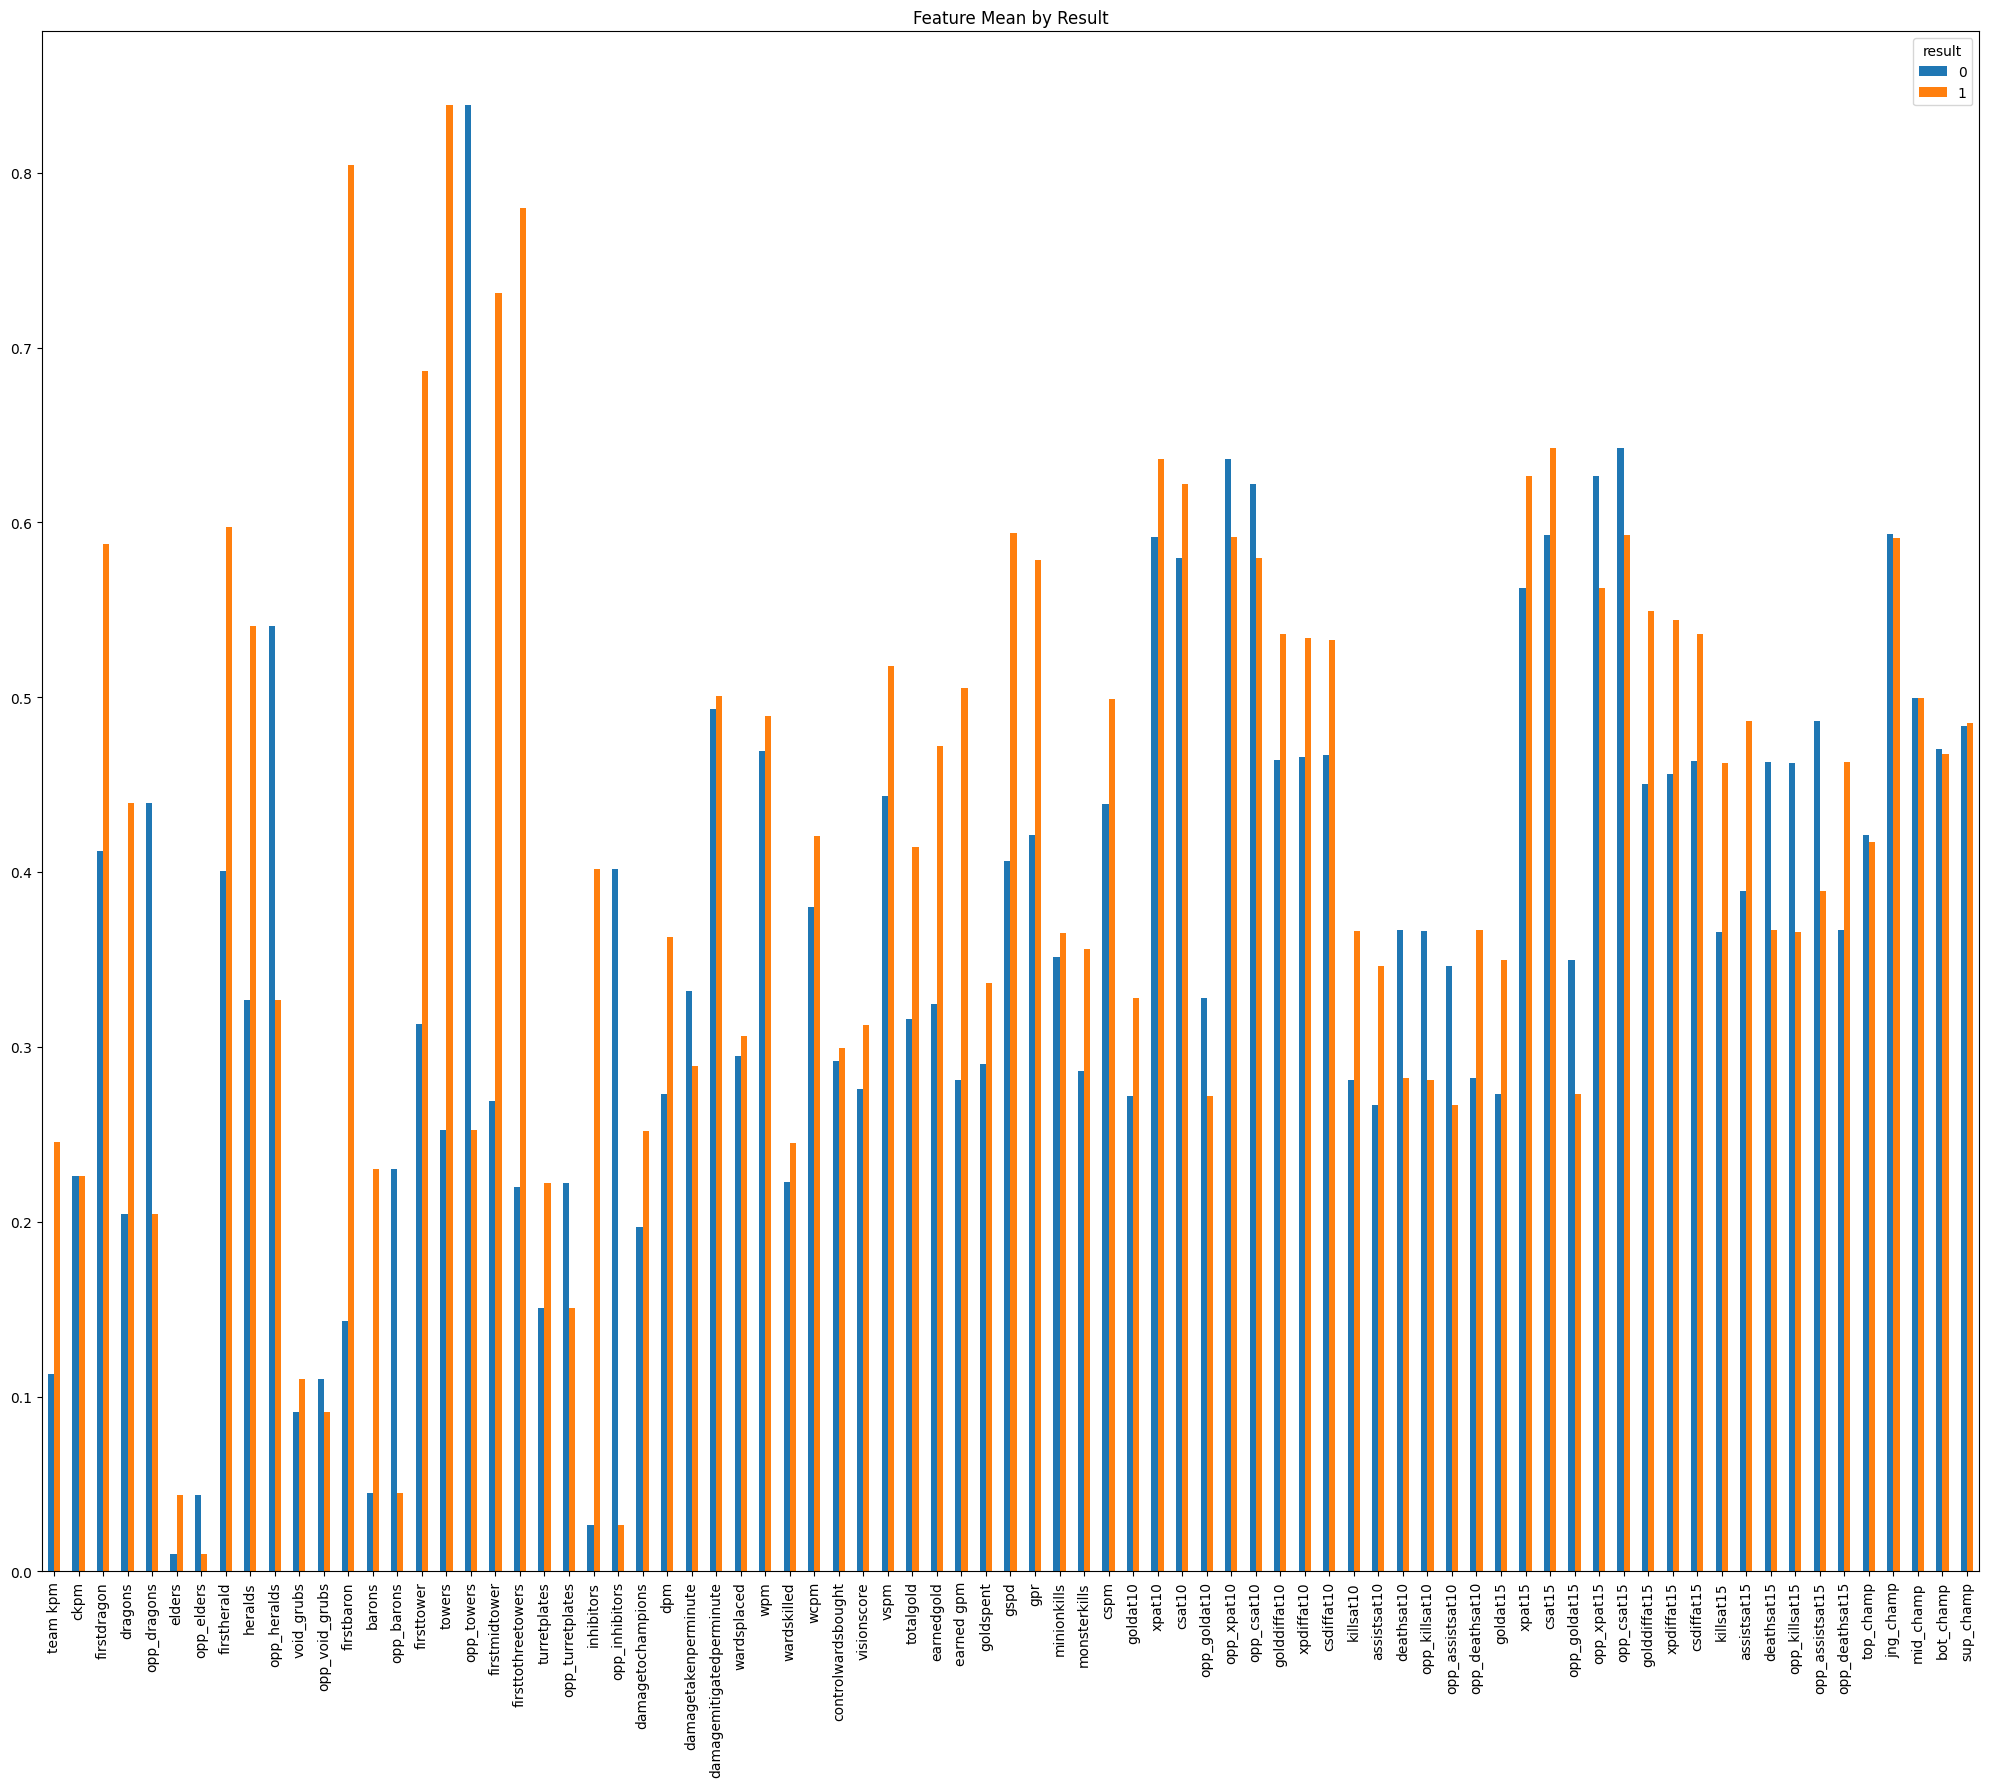

In [16]:
grouped_means = df.groupby('result').mean()
display(grouped_means)

df.groupby('result').mean().T.plot(kind='bar', figsize=(25, 20), title='Feature Mean by Result')


### Feature Correlation Matrix / Heatmap

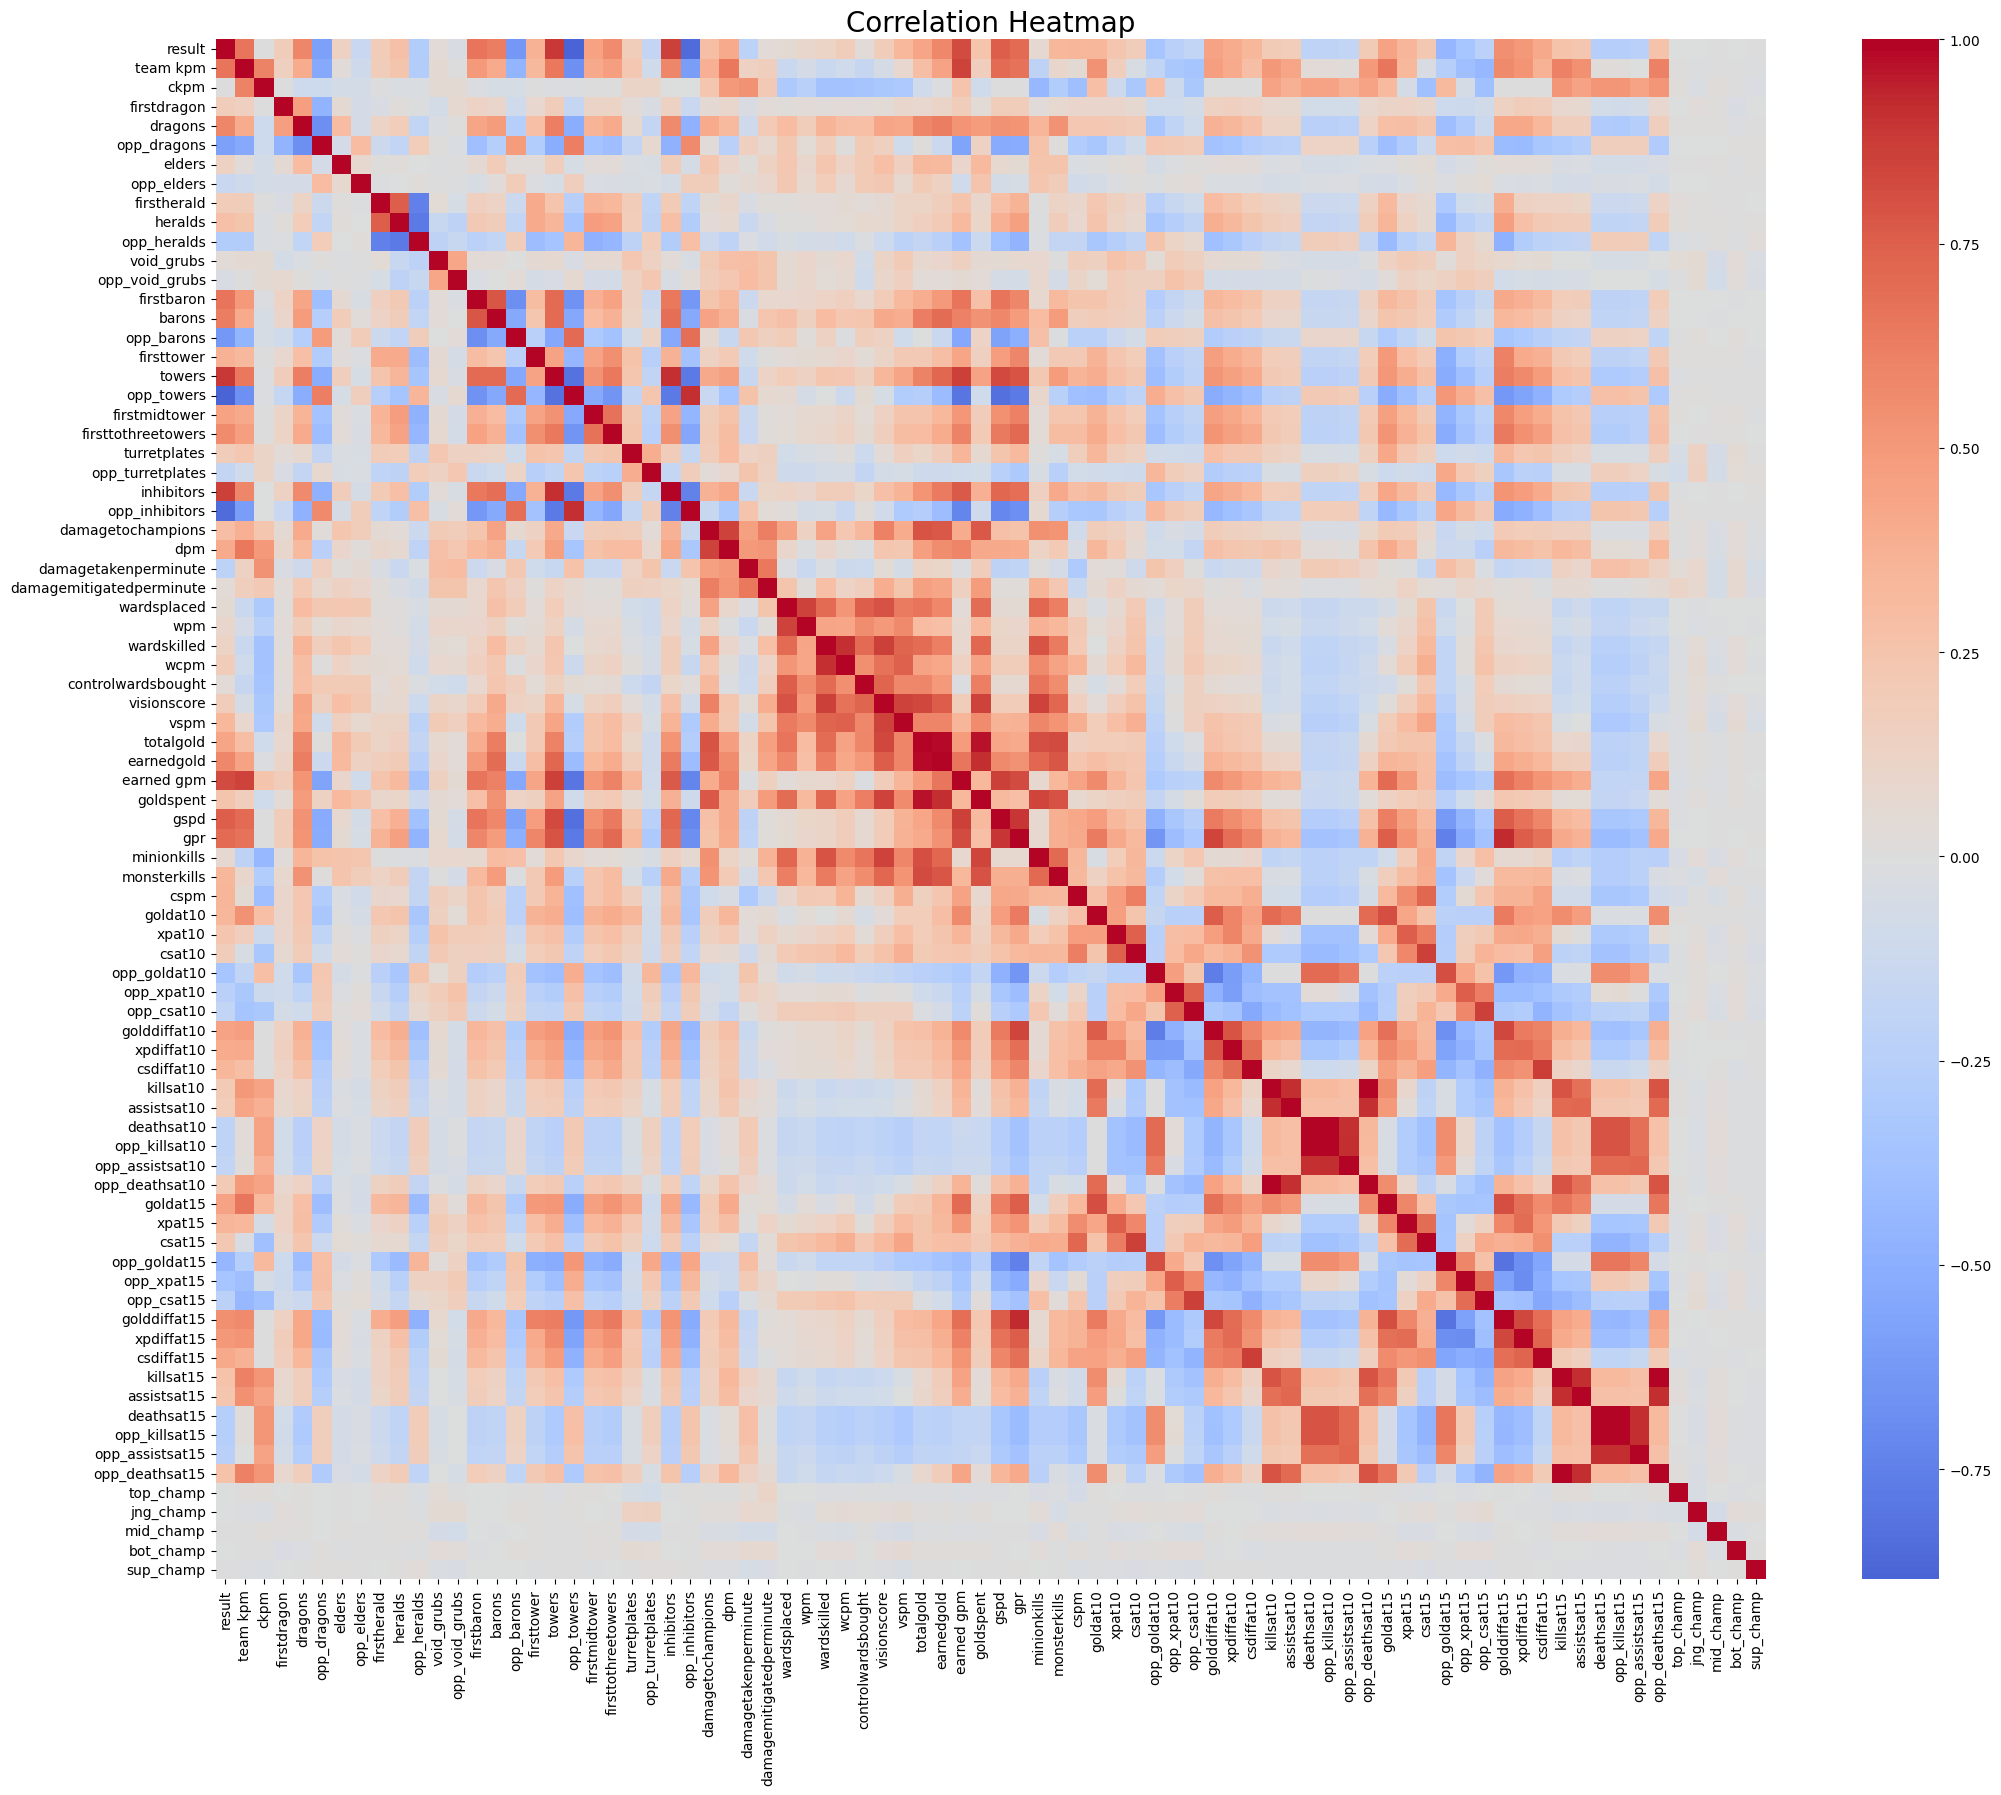

In [17]:
import seaborn as sns

# correlation_matrix = df.corr()
# display(correlation_matrix)

plt.figure(figsize=(25, 20))
sns.heatmap(df.corr(), cmap='coolwarm', center=0, annot=False)
plt.title('Correlation Heatmap', fontsize=20)
plt.show()

## Save the processed data to Parquet

In [ ]:
df.to_parquet("data/processed_lol_data.parquet", index=False)

# Model Training


## Load Processed data

In [19]:
df = pd.read_parquet("data/processed_lol_data.parquet")

## Prepare data loader

In [20]:
def create_dataloaders(df, batch_size=64, test_size=0.2, seed=42):
    from sklearn.model_selection import train_test_split
    from torch.utils.data import Dataset, DataLoader
    import torch

    class LoLDataset(torch.utils.data.Dataset):
        def __init__(self, df):
            self.X = torch.tensor(df.drop(columns=['result']).values, dtype=torch.float32)
            self.y = torch.tensor(df['result'].values, dtype=torch.long)

        def __len__(self):
            return len(self.X)

        def __getitem__(self, idx):
            return self.X[idx], self.y[idx]

    train_df, test_df = train_test_split(df, test_size=test_size, random_state=seed, stratify=df['result'])

    train_dataset = LoLDataset(train_df)
    test_dataset = LoLDataset(test_df)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


## Define DNN Model

In [5]:
import torch.nn as nn

class LoLNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=2):
        super(LoLNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)


## Define Training Loop

In [22]:
import torch
import optuna
from sklearn.metrics import accuracy_score

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, device='cpu', trial=None, patience=3):
    model.to(device)
    best_acc = 0
    epoch_log = []
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        all_preds, all_labels = [], []

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

        train_acc = accuracy_score(all_labels, all_preds)

        model.eval()
        test_preds, test_labels = [], []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                preds = torch.argmax(outputs, dim=1)
                test_preds.extend(preds.cpu().numpy())
                test_labels.extend(y_batch.cpu().numpy())

        test_acc = accuracy_score(test_labels, test_preds)
        print(f"🧪 Epoch {epoch+1:>2}/{num_epochs:<2} | "
            f"Loss: {total_loss:10.4f} | "
            f"Train Acc: {train_acc:7.4f} | "
            f"Test Acc: {test_acc:7.4f}")


        
        epoch_log.append({
            'epoch': epoch + 1,
            'train_acc': train_acc,
            'test_acc': test_acc,
            'loss': total_loss
        })
        
        if test_acc > best_acc:
            best_acc = test_acc
            best_epoch = epoch
            best_model_state = model.state_dict()
        elif epoch - best_epoch >= patience:
            print(f"⏹️ Early stopping at epoch {epoch+1} (no improvement for {patience} epochs)")
            break

        # if trial is not None:
        #     trial.report(test_acc, step=epoch)
        #     if trial.should_prune():
        #         print(f"🔪 Trial pruned at epoch {epoch+1}")
        #         raise optuna.TrialPruned()

        best_acc = max(best_acc, test_acc)

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        
    return best_acc, epoch_log




/home/quiet98k/anaconda3/envs/lol/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define parameter tuning function

In [23]:
import optuna
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score

def objective(trial):
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256])
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    # patience = trial.suggest_int("patience", 2, 6)
    patience = 6
    num_epochs = trial.suggest_int("num_epochs", 10, 50)
    # num_epochs = 30 
    

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, test_loader = create_dataloaders(df, batch_size=batch_size)
    input_dim = df.drop(columns=['result']).shape[1]

    model = LoLNet(input_dim=input_dim, hidden_dim=hidden_dim).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    acc, epoch_log = train_model(
        model, train_loader, test_loader, 
        criterion, optimizer, 
        num_epochs=num_epochs, device=device,
        trial=trial, patience=patience
    )
    
    trial.set_user_attr("epoch_log", epoch_log)

    model_path = f"models/trials/model_trial_{trial.number}.pth"
    torch.save(model.state_dict(), model_path)
    trial.set_user_attr("saved_model_path", model_path)
    print(f"💾 Model for Trial {trial.number} saved to: {model_path}")


    return acc

## Start Tuning

In [24]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
import shutil

def callback(study, trial):
    best = study.best_trial
    print(f"✅ Trial {trial.number} | Accuracy: {trial.value:.4f} | Params: {trial.params} | "
          f"🏆 Best: Trial {best.number} ({best.value:.4f}) \n")

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, callbacks=[callback])


best_model_path_before = study.best_trial.user_attrs["saved_model_path"]
best_model_path_after = f"models/best_model.pth"
shutil.copy(best_model_path_before, best_model_path_after)
print(f"✅ Best model copied to: {best_model_path_after}")



🧪 Epoch  1/46 | Loss:    29.5281 | Train Acc:  0.9790 | Test Acc:  0.9865
🧪 Epoch  2/46 | Loss:    19.2639 | Train Acc:  0.9860 | Test Acc:  0.9880
🧪 Epoch  3/46 | Loss:    16.4954 | Train Acc:  0.9879 | Test Acc:  0.9886
🧪 Epoch  4/46 | Loss:    14.4567 | Train Acc:  0.9895 | Test Acc:  0.9902
🧪 Epoch  5/46 | Loss:    15.2201 | Train Acc:  0.9892 | Test Acc:  0.9913
🧪 Epoch  6/46 | Loss:    12.5011 | Train Acc:  0.9913 | Test Acc:  0.9904
🧪 Epoch  7/46 | Loss:    12.7628 | Train Acc:  0.9914 | Test Acc:  0.9925
🧪 Epoch  8/46 | Loss:    11.3481 | Train Acc:  0.9926 | Test Acc:  0.9943
🧪 Epoch  9/46 | Loss:    10.9829 | Train Acc:  0.9924 | Test Acc:  0.9919
🧪 Epoch 10/46 | Loss:    10.4354 | Train Acc:  0.9929 | Test Acc:  0.9942
🧪 Epoch 11/46 | Loss:    10.6819 | Train Acc:  0.9926 | Test Acc:  0.9936
🧪 Epoch 12/46 | Loss:     9.5967 | Train Acc:  0.9935 | Test Acc:  0.9938
🧪 Epoch 13/46 | Loss:     9.2743 | Train Acc:  0.9938 | Test Acc:  0.9913
🧪 Epoch 14/46 | Loss:     9.9051 | Tra

## Save training logs

In [25]:
import pandas as pd

trial_data = []

for trial in study.trials:
    if trial.state == optuna.trial.TrialState.COMPLETE:
        row = {
            "trial": trial.number,
            "accuracy": trial.value,
            **trial.params,  
        }

        if "epoch_log" in trial.user_attrs:
            row["actual_epochs"] = len(trial.user_attrs["epoch_log"])

        if "saved_model_path" in trial.user_attrs:
            row["model_path"] = trial.user_attrs["saved_model_path"]

        trial_data.append(row)

df_trials = pd.DataFrame(trial_data)
df_trials.to_csv("training_log/trial_results.csv", index=False)
print("✅ Saved trial results to trial_results.csv")


✅ Saved trial results to trial_results.csv


In [26]:
epoch_logs = []

for trial in study.trials:
    if trial.state == optuna.trial.TrialState.COMPLETE and "epoch_log" in trial.user_attrs:
        for e in trial.user_attrs["epoch_log"]:
            log_row = {
                "trial": trial.number,
                **trial.params,
                **e  
            }
            epoch_logs.append(log_row)

df_epochs = pd.DataFrame(epoch_logs)
df_epochs.to_csv("training_log/epoch_logs.csv", index=False)
print("✅ Saved per-epoch logs to epoch_logs.csv")


✅ Saved per-epoch logs to epoch_logs.csv


## Get Best Trial

In [27]:
best_trial = study.best_trial

print(f"🏆 Best Trial: {best_trial.number}")
print(f"✅ Accuracy: {best_trial.value:.4f}")
print(f"📦 Hyperparameters: {best_trial.params}")


🏆 Best Trial: 71
✅ Accuracy: 0.9957
📦 Hyperparameters: {'batch_size': 128, 'hidden_dim': 64, 'lr': 0.0017658106174004541, 'num_epochs': 35}


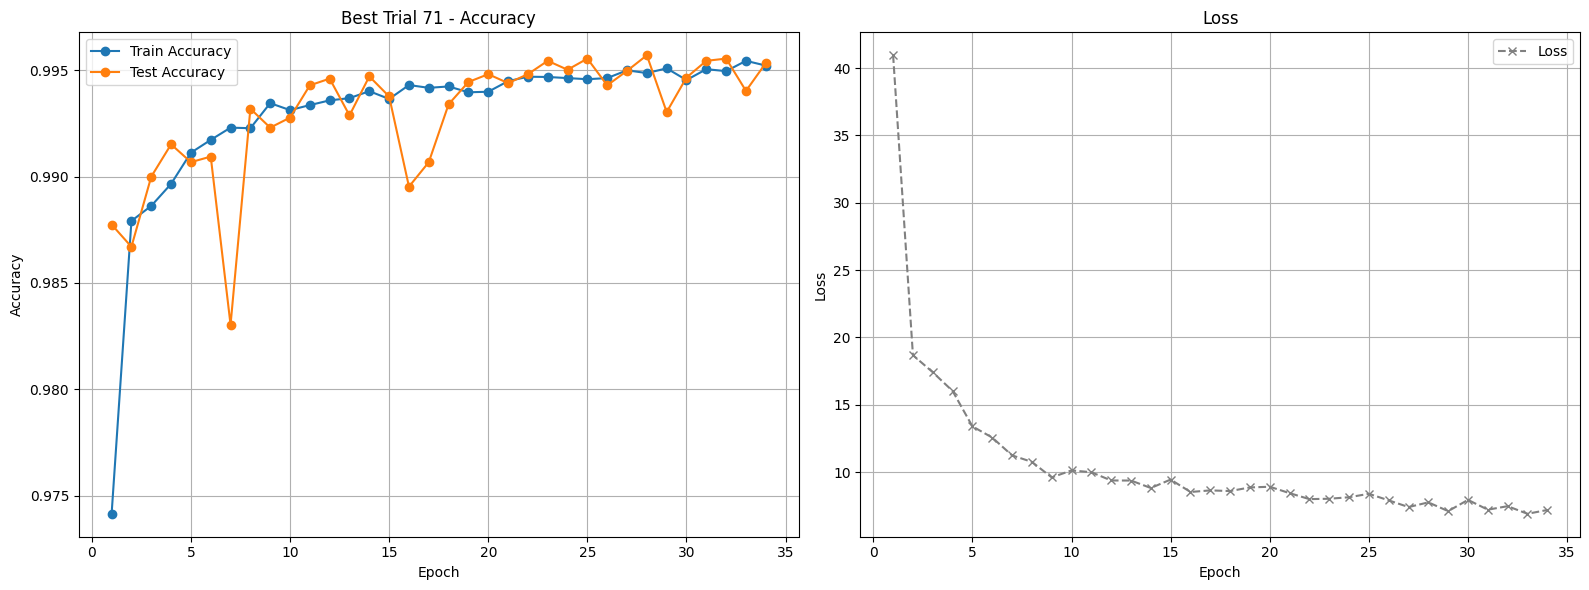

In [28]:
import matplotlib.pyplot as plt

# Get best trial and epoch log
best_trial = study.best_trial
epoch_log = best_trial.user_attrs["epoch_log"]

# Extract values
epochs     = [e['epoch'] for e in epoch_log]
train_accs = [e['train_acc'] for e in epoch_log]
test_accs  = [e['test_acc'] for e in epoch_log]
losses     = [e['loss'] for e in epoch_log]

# Create two side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy plot
ax1.plot(epochs, train_accs, label="Train Accuracy", marker='o')
ax1.plot(epochs, test_accs, label="Test Accuracy", marker='o')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.set_title(f"Best Trial {best_trial.number} - Accuracy")
ax1.legend()
ax1.grid(True)

# Loss plot
ax2.plot(epochs, losses, label="Loss", color='gray', linestyle='--', marker='x')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.set_title("Loss")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Local Robustness

## Load the model and processed dataset

In [7]:
import pandas as pd
import torch
import torch.nn as nn

df = pd.read_parquet("data/processed_lol_data.parquet")
input_dim = df.drop(columns=['result']).shape[1]
hidden_dim = 64
model = LoLNet(input_dim, hidden_dim=hidden_dim)
model.load_state_dict(torch.load('models/best_model.pth'))
model.eval()  

LoLNet(
  (model): Sequential(
    (0): Linear(in_features=79, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)

## Export to onnx

In [11]:
dummy_input = torch.randn(1, input_dim)  # Shape: [1, number of features]
onnx_path = "models/lolnet.onnx"

torch.onnx.export(
    model, 
    dummy_input, 
    onnx_path,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}},
    opset_version=11  # Use >=11 to support ReLU, Linear, etc.
)



✅ ONNX model is valid.
